This example demonstrates the calculation of bilayer fractional quantum Hall states using the Halperin (m,m',n) wavefunction.

## Physical System
- **Two-layer system**: Each layer can hold electrons with inter-layer tunneling
- **Halperin (m,m',n) state**: Generalization of Laughlin state to bilayer systems. For (3,3,1) state, the filling factors are 1/4 for both layers.
- **Inter-layer distance**: d
- **Tunneling strength**: t
- **Energy offset**: ΔE

## Key Features
- **Layer conservation**: Interaction conserves layer component of each scattering vertex (ci1=cf1, ci2=cf2)
- **Layer-dependent interaction**: Extra e^{-ql*d_l} factor for different-layer interaction

## System Parameters

### Lattice Geometry
- Triangular lattice with vectors G1 = (G, 0), G2 = (-G/2, sqrt(3)*G/2)
- Landau level n=0
- Brillouin zone area = 2π/l² = sqrt(0.75) * G²

### Bilayer Parameters
- **Nc = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t / W0, if t=0, layer becomes conserved
- **Layer conservation**: Interactions preserve layer indices

### Interaction Details
- **Same-layer interaction**: Identical to single-layer case
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: V(q) = W0 * 1/|ql| * tanh(|qD|) 

In [1]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Number of layers (components) for bilayer system
Nc_hopping = 2

# Define k-mesh for bilayer system (2×3 mesh, Nk=6) in triangular lattice
# Using a smaller mesh for computational efficiency
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne = 6

6

In [18]:
# Physical parameters
Gl = sqrt(2π/sqrt(0.75))   # Magnetic length scale
D_l = 5.0                  # Screening length D/l
W0 = 1.0                   # Interaction strength
G12_angle = 2π/3           # Angle between reciprocal lattice vectors (triangular lattice)
d_l = 0.1                  # Inter-layer distance d/l
t = 0.0 * W0              # Inter-layer tunneling strength
ΔE = 0 * W0              # Energy difference between the two layers


# Define the form factor for Coulomb interaction in Landau level
# This includes the Landau level projection exp(-0.5 * q²l²)
# For bilayer: add extra e^{-ql*d/l} factor for different-layer interactions
function VFF_bilayer(q1::Float64, q2::Float64; diff_layer=false)
    ql = sqrt(q1^2 + q2^2 + 2cos(G12_angle) * q1*q2) * Gl
    if ql == 0.0
        return W0 * D_l  # Regularization at q=0
    end
    
    V = W0 / ql * tanh(ql * D_l) * exp(-0.5 * ql^2)
    
    # Apply inter-layer attenuation factor for different-layer interactions
    if diff_layer
        return V * exp(-ql * d_l)  # Exponential attenuation with distance d_l
    end
    
    return V
end

# Sign function for reciprocal lattice vectors
# Determines the phase structure of the magnetic translation group
function ita(g1::Int64, g2::Int64)
    if iseven(g1) && iseven(g2)
        return 1
    else
        return -1
    end
end

# Cross product for 2D vectors (returns scalar)
# Used for computing geometric phases in magnetic field
function ql_cross(q1_1, q1_2, q2_1, q2_2)
    return q1_1 * q2_2 - q1_2 * q2_1
end

# Bilayer interaction function - same structure as single-layer but with layer-dependent VFF
function V_int_bilayer(kf1, kf2, ki2, ki1, cf1=1, cf2=1, ci2=1, ci1=1; output=false)::ComplexF64
    
    # Layer conservation: interaction must conserve layer indices
    if ci1 != cf1 || ci2 != cf2
        return 0.0 + 0.0im
    end
    
    
    # Calculate momentum transfer (modulo reciprocal lattice)
    q = rem.(ki1 .- kf1, 1, RoundNearest)
    G_shift1 = round.(Int64, ki1 .- kf1 .- q, RoundNearest)
    G_shift2 = round.(Int64, kf2 .- ki2 .- q, RoundNearest)


    V_total = ComplexF64(0.0)
    # Sum over reciprocal lattice vectors for convergence
    Nshell = 2
    for g1 in -Nshell:Nshell, g2 in -Nshell:Nshell
        if abs(g1-g2) > Nshell
            continue
        end

        # Construct the full momentum transfer including reciprocal lattice
        qq1 = q[1] + g1
        qq2 = q[2] + g2

        # Calculate phase factors from magnetic translation algebra
        # These phases ensure proper commutation relations and gauge invariance
        phase_angle = 0.5ql_cross(ki1[1], ki1[2], kf1[1], kf1[2])
        phase_angle += 0.5ql_cross(ki1[1]+kf1[1], ki1[2]+kf1[2], qq1, qq2)
        phase_angle += 0.5ql_cross(ki2[1], ki2[2], kf2[1], kf2[2])
        phase_angle += 0.5ql_cross(ki2[1]+kf2[1], ki2[2]+kf2[2], -qq1, -qq2)

        phase = cispi(2.0phase_angle)
        sign = ita(g1+G_shift1[1], g2+G_shift1[2]) * ita(g1+G_shift2[1], g2+G_shift2[2])

        # Use layer-dependent form factor
        vff = VFF_bilayer(qq1, qq2; diff_layer=(ci1 != ci2))
        V_total += sign * phase * vff
    end

    return V_total
end

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : hopping from component c2 to c1 at momentum k
# For bilayer system: Nc_hopping=2, Nc_conserve=1, Nk=6
H_onebody_bilayer = zeros(ComplexF64, Nc_hopping, Nc_hopping, 1, Nk)

# Add tunneling terms: t = 0.5 * W0 between different layers
# Tunneling conserves momentum (diagonal in k-space)
for k_idx in 1:Nk
    # Hopping from layer 2 to layer 1
    H_onebody_bilayer[1, 2, 1, k_idx] = t
    # Hopping from layer 1 to layer 2  
    H_onebody_bilayer[2, 1, 1, k_idx] = t
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[2, 2, 1, k_idx] = -0.5ΔE
end

# Create parameter structure for bilayer system
# Note: H_onebody matrix handles tunneling, V_int handles interactions
para_bilayer = EDPara(
    k_list=k_list, 
    Gk=Gk, 
    Nc_hopping=Nc_hopping,
    Nc_conserve=1,
    H_onebody=H_onebody_bilayer,
    V_int=V_int_bilayer
);

In [19]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_bilayer, ED_mbslist(para_bilayer, (Ne,)));
length.(blocks)

12-element Vector{Int64}:
 11202
 11196
 11196
 11240
 11232
 11232
 11202
 11196
 11196
 11240
 11232
 11232

In [20]:
# Generate scattering lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatteringList_onebody(para_bilayer);
scat_list2 = ED_sortedScatteringList_twobody(para_bilayer);

In [21]:
Neigen = 6
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat_list1, scat_list2, Neigen; 
        showtime=true, converge_warning = false
    )
end

Processing block #1 with size 11202, momentum 0, 0
  0.720552 seconds (36.33 M allocations: 749.561 MiB, 44.41% gc time, 0.03% compilation time)
  1.273901 seconds (12.40 k allocations: 266.362 MiB, 10.12% gc time)
Processing block #2 with size 11196, momentum 0, 1
  0.591214 seconds (36.28 M allocations: 747.677 MiB, 30.33% gc time)
  1.213710 seconds (10.89 k allocations: 234.234 MiB, 10.10% gc time)
Processing block #3 with size 11196, momentum 0, 2
  0.600022 seconds (36.28 M allocations: 747.680 MiB, 27.31% gc time)
  1.029929 seconds (10.41 k allocations: 223.930 MiB, 3.29% gc time)
Processing block #4 with size 11240, momentum 1, 0
  0.584694 seconds (36.44 M allocations: 751.283 MiB, 31.01% gc time)
  1.529821 seconds (14.88 k allocations: 323.743 MiB, 8.90% gc time)
Processing block #5 with size 11232, momentum 1, 1
  0.564326 seconds (36.41 M allocations: 750.578 MiB, 28.30% gc time)
  1.080046 seconds (10.38 k allocations: 224.642 MiB, 3.15% gc time)
Processing block #6 with

In [22]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

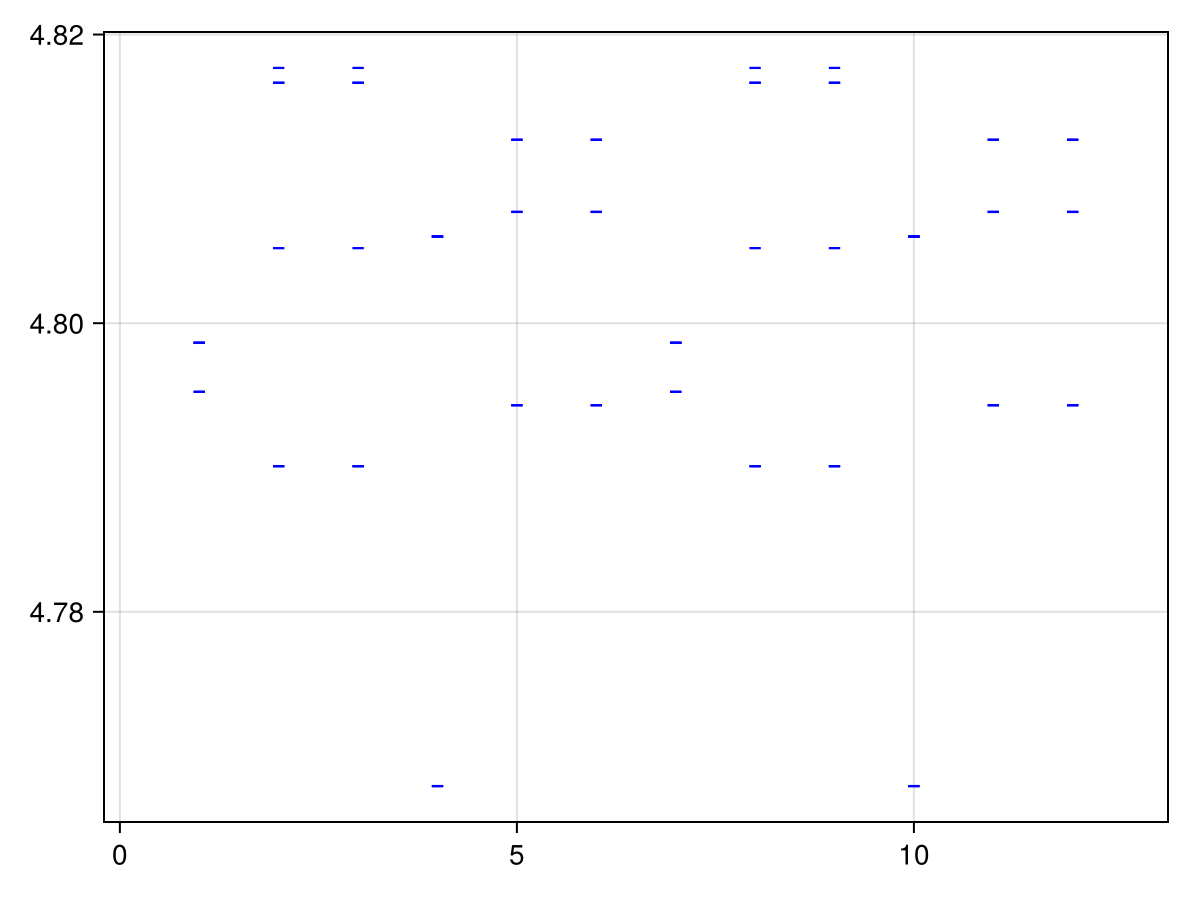

In [24]:
# Plot energy spectrum
using CairoMakie
CairoMakie.activate!()

begin
    fig = Figure();
    ax = Axis(fig[1, 1])
    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, i, e, color = :blue, marker=:hline)
        end
    end
    xlims!(-0.2, 1.2+length(blocks))
    fig
end
# display(fig)

In [25]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
bn = 4 # the block number to inspect
energies[bn]

6-element Vector{Float64}:
 4.767925049245055
 4.767925049245066
 4.806002585506755
 4.806002585506784
 4.806002588053905
 4.806002588053907

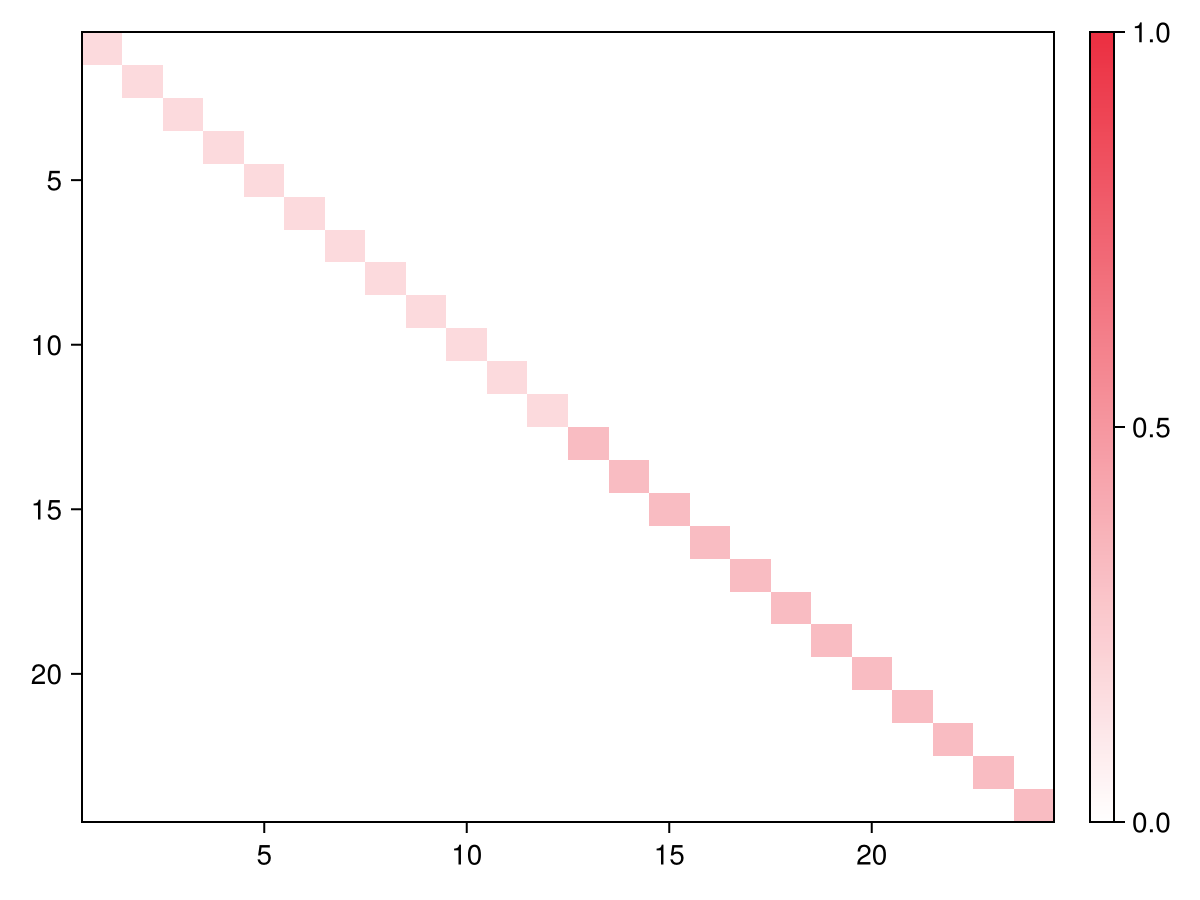

In [26]:
# plot the reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])
begin
    fig = Figure();
    ax = Axis(fig[1, 1]; yreversed = true)
    hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    fig
end

In the specific case when interlayer tunneling t=0, particle numbers of the two layers are conserved.

With this, we can do larger system.

In [27]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Number of layers (components) for bilayer system
Nc_conserve = 2

# Define k-mesh for bilayer system (2×3 mesh, Nk=6) in triangular lattice
# Using a smaller mesh for computational efficiency
k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Nk = 16
Gk = (4, 4)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne1 = 4
Ne2 = 4

4

In [28]:
# Physical parameters
t = 0.0                    # must be zero for layer-conserved case
ΔE = 0 * W0                # Energy difference between the two layers


# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, Nk=6
H_onebody_bilayer = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
# Add energy difference terms: ΔE = 0.5 * W0 between different layers
# No tunneling
for k_idx in 1:Nk
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[1, 1, 2, k_idx] = -0.5ΔE
end

# Create parameter structure for bilayer system
# Note: H_onebody matrix handles tunneling, V_int handles interactions
para_bilayer = EDPara(
    k_list=k_list, 
    Gk=Gk, 
    Nc_hopping=1,
    Nc_conserve=Nc_conserve,
    H_onebody=H_onebody_bilayer,
    V_int=V_int_bilayer
);

In [29]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_bilayer, ED_mbslist(para_bilayer, (Ne1,Ne2)));
length.(blocks)

16-element Vector{Int64}:
 207184
 206976
 207168
 206976
 206976
 206976
 206976
 206976
 207168
 206976
 207168
 206976
 206976
 206976
 206976
 206976

In [30]:
# Generate scattering lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatteringList_onebody(para_bilayer);
scat_list2 = ED_sortedScatteringList_twobody(para_bilayer);

In [31]:
# Time cost is significantly higher with this larger system size
# use tol=W0*1e-6 to speed up convergence
energies = Vector{Vector{Float64}}(undef, length(blocks))
Neigen = 6
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    if i == k0number
        energies[i] = EDsolve(blocks[i], scat_list1, scat_list2, 2Neigen; showtime=true, converge_warning = false, tol=W0*1e-6)[1]
    else
        energies[i] = EDsolve(blocks[i], scat_list1, scat_list2, Neigen; showtime=true, converge_warning = false, tol=W0*1e-6)[1]
    end
end

Processing block #1 with size 207184, momentum 0, 0
 30.021922 seconds (1.66 G allocations: 33.626 GiB, 17.62% gc time, 3.93% compilation time)
 57.232200 seconds (20.79 k allocations: 7.776 GiB, 2.76% gc time)
Processing block #2 with size 206976, momentum 0, 1
 40.297568 seconds (1.65 G allocations: 33.573 GiB, 20.27% gc time)
 32.640475 seconds (9.03 k allocations: 3.468 GiB, 2.27% gc time)
Processing block #3 with size 207168, momentum 0, 2
 41.525967 seconds (1.66 G allocations: 33.613 GiB, 19.75% gc time)
 34.514660 seconds (10.37 k allocations: 3.953 GiB, 2.49% gc time)
Processing block #4 with size 206976, momentum 0, 3
 38.915819 seconds (1.65 G allocations: 33.573 GiB, 19.51% gc time)
 27.768146 seconds (8.32 k allocations: 3.190 GiB, 2.55% gc time)
Processing block #5 with size 206976, momentum 1, 0
 39.311326 seconds (1.65 G allocations: 33.573 GiB, 20.21% gc time)
 26.853756 seconds (8.07 k allocations: 3.097 GiB, 2.60% gc time)
Processing block #6 with size 206976, moment

In [14]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

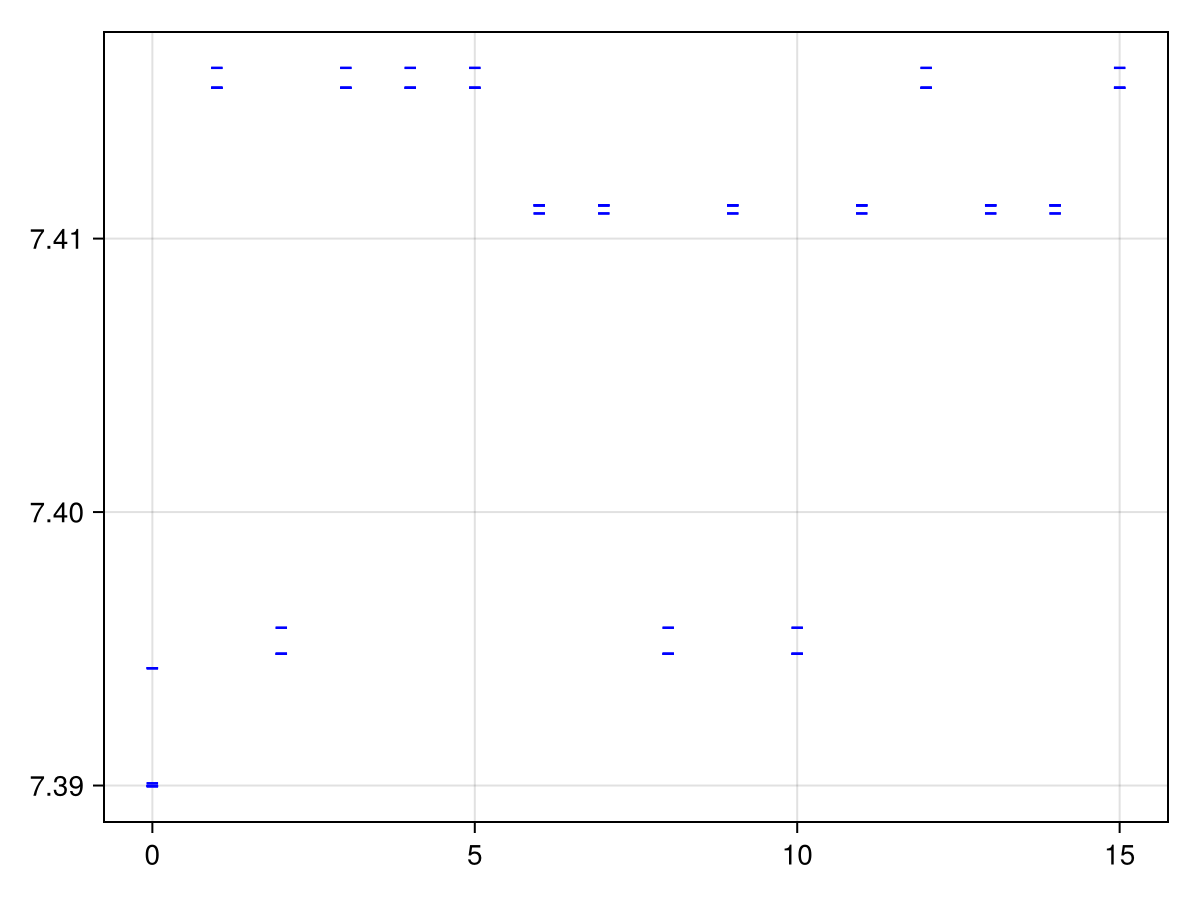

CairoMakie.Screen{IMAGE}


In [15]:
# Plot energy spectrum
using CairoMakie
CairoMakie.activate!()

begin
    fig = Figure();
    ax = Axis(fig[1, 1])    
    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, Gk[2]*block_k1[i]+block_k2[i], e, color = :blue, marker=:hline)
        end
    end
    fig
end
display(fig)

In [16]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
energies[1]

12-element Vector{Float64}:
 7.389980240167975
 7.3899802787307225
 7.389980309136654
 7.389980360558108
 7.389980392617043
 7.389980448097751
 7.39008101514381
 7.390081015161232
 7.39429261624351
 7.394292632796416
 7.394292650860737
 7.39429268392222